<center> 
    <a href="https://www.visual-layer.com" target="_blank" rel="noopener noreferrer">
    <picture>
    <source media="(prefers-color-scheme: dark)" srcset="https://raw.githubusercontent.com/visual-layer/visuallayer/main/imgs/vl_horizontal_logo_dark_mode.png" width=200>
    <source media="(prefers-color-scheme: light)" srcset="https://raw.githubusercontent.com/visual-layer/visuallayer/main/imgs/vl_horizontal_logo.png" width=200>
    <img alt="vl logo." src="https://raw.githubusercontent.com/visual-layer/fastdup/main/gallery/visual_layer_logo.png" width=400>
    </picture>
    </a><br>
    <a href="https://github.com/visual-layer/fastdup" target="_blank" style="text-decoration: none;"> GitHub </a> •
    <a href="https://discord.com/invite/Dqw458EG/" target="_blank" style="text-decoration: none;"> Join Discord Community </a> •
    <a href="https://visual-layer.readme.io/discuss" target="_blank" style="text-decoration: none;"> Discussion Forum </a>
</center>

<center> 
    <a href="https://medium.com/visual-layer" target="_blank" style="text-decoration: none;"> Blog </a> •
    <a href="https://visual-layer.readme.io/" target="_blank" style="text-decoration: none;"> Documentation </a> •
    <a href="https://visual-layer.com/about" target="_blank" style="text-decoration: none;"> About Us </a> 
</center>


<br>

<center> 
<div style="text-align: center; margin-top:50px;">
    <a href="https://visual-layer.com/" style="padding:10px;">
                <img alt="site" src="https://vl-blog.s3.us-east-2.amazonaws.com/imgs/web.png" width="50"></a>
    <a href="https://medium.com/visual-layer" style="padding:10px;">
                <img alt="blog" src="https://vl-blog.s3.us-east-2.amazonaws.com/imgs/forum.png" width="50"></a>
    <a href="https://github.com/visual-layer/fastdup" style="padding:10px;">
                <img alt="github" src="https://vl-blog.s3.us-east-2.amazonaws.com/imgs/github.png" width="50"></a>
    <a href="https://discord.com/invite/Dqw458EG/" style="padding:10px;">
                <img alt="slack" src="https://vl-blog.s3.us-east-2.amazonaws.com/imgs/discord.png" width="50"></a>
    <a href="https://www.linkedin.com/company/visual-layer/" style="padding:10px;">
                <img alt="linkedin" src="https://vl-blog.s3.us-east-2.amazonaws.com/imgs/linkedin.png" width="50"></a>
    <a href="https://www.youtube.com/@visual-layer" style="padding:10px;">
                <img alt="youtube" src="https://vl-blog.s3.us-east-2.amazonaws.com/imgs/youtube.png" width="50"></a>
    <a href="https://twitter.com/visual_layer" style="padding:10px;">
                <img alt="twitter" src="https://vl-blog.s3.us-east-2.amazonaws.com/imgs/x.png" width="50"></a>
</div>
</center>

# Analyzing Hugging Face Datasets

[![Open in Colab](https://img.shields.io/badge/Open%20in%20Colab-blue?style=for-the-badge&logo=google-colab&labelColor=gray)](https://colab.research.google.com/github/visual-layer/fastdup/blob/main/examples/analyzing-hf-datasets.ipynb)
[![Open in Kaggle](https://img.shields.io/badge/Open%20in%20Kaggle-blue?style=for-the-badge&logo=kaggle&labelColor=gray)](https://kaggle.com/kernels/welcome?src=https://github.com/visual-layer/fastdup/blob/main/examples/analyzing-hf-datasets.ipynb)
[![Explore the Docs](https://img.shields.io/badge/Explore%20the%20Docs-blue?style=for-the-badge&labelColor=gray&logo=read-the-docs)](https://visual-layer.readme.io/docs/analyzing-hf-datasets)

This notebook shows how you can use fastdup to analyze any dataset from [Hugging Face Datasets](https://huggingface.co/docs/datasets/index).

We will analyze an image classification dataset for:

+ Duplicates / near-duplicates
+ Outliers
+ Wrong labels

## Installation

In [ ]:
!pip install -Uq fastdup datasets

In [ ]:
!pip install -Uq pillow

Now, test the installation. If there's no error message, we are ready to go.

In [2]:
import fastdup
fastdup.__version__

'2.0.21'

## Load Dataset

In this example we load the Tiny ImageNet dataset from [Hugging Face Datasets](https://huggingface.co/datasets)..

Tiny ImageNet contains 100,000 images of 200 classes (500 for each class) downsized to 64×64 colored images. Each class has 500 training images, 50 validation images, and 50 test images.

Let's load the dataset into our local directory.

In [3]:
from fastdup.datasets import FastdupHFDataset

In [4]:
dataset = FastdupHFDataset("zh-plus/tiny-imagenet", split="train")

We can inspect the `dataset` object.

In [5]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 100000
})

In [6]:
dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 'label': 0}

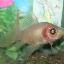

In [7]:
dataset[0]['image']

In [8]:
dataset[0]['label']

0

In [9]:
dataset.annotations

,filename,label
0,/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/142/71384.jpg,142
1,/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/142/71204.jpg,142
2,/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/142/71036.jpg,142
3,/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/142/71014.jpg,142
4,/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/142/71334.jpg,142
...,...,...
99995,/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/127/63864.jpg,127
99996,/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/127/63822.jpg,127
99997,/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/127/63874.jpg,127
99998,/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/127/63824.jpg,127


## Run fastdup

In [ ]:
fd = fastdup.create(input_dir=dataset.img_dir)
fd.run(annotations=dataset.annotations)

## Inspect Issues

There are several methods we can use to inspect the issues found:

```python
fd.vis.duplicates_gallery()    # create a visual gallery of duplicates
fd.vis.outliers_gallery()      # create a visual gallery of anomalies
fd.vis.component_gallery()     # create a visualization of connected components
fd.vis.stats_gallery()         # create a visualization of images statistics (e.g. blur)
fd.vis.similarity_gallery()    # create a gallery of similar images
```

/home/dnth/anaconda3/envs/fastdup2021/lib/python3.10/site-packages/fastdup/galleries.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[out_col] = df[in_col].apply(lambda x: get_label_func.get(x, MISSING_LABEL))
/home/dnth/anaconda3/envs/fastdup2021/lib/python3.10/site-packages/fastdup/galleries.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[out_col] = df[in_col].apply(lambda x: get_label_func.get(x, MISSING_LABEL))


Generating gallery:   0%|          | 0/20 [00:00<?, ?it/s]

Stored similarity visual view in  work_dir/galleries/duplicates.html
########################################################################################
Would you like to see awesome visualizations for some of the most popular academic datasets?
Click here to see and learn more: https://app.visual-layer.com/vl-datasets?utm_source=fastdup
########################################################################################



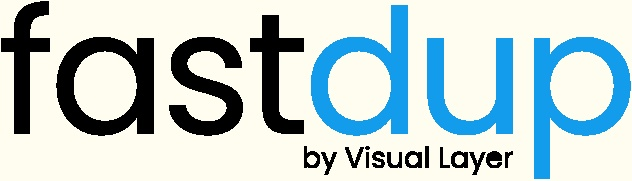
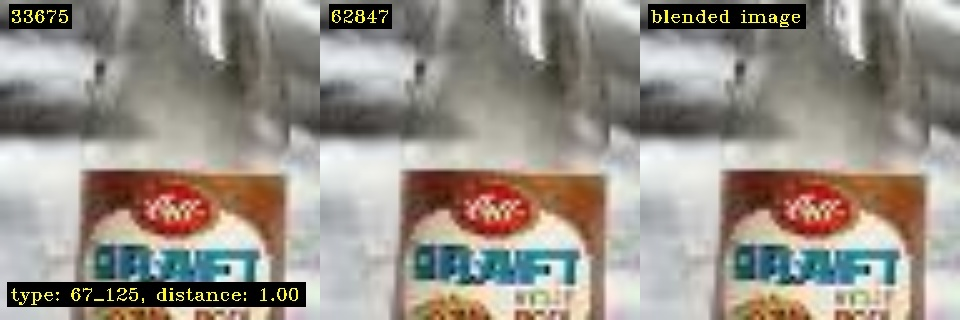
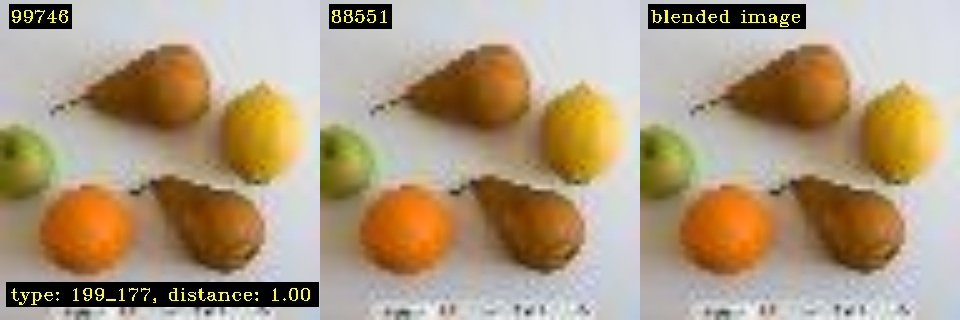
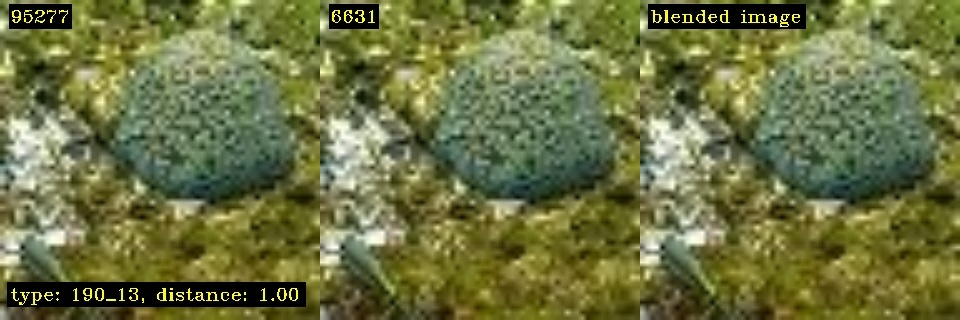
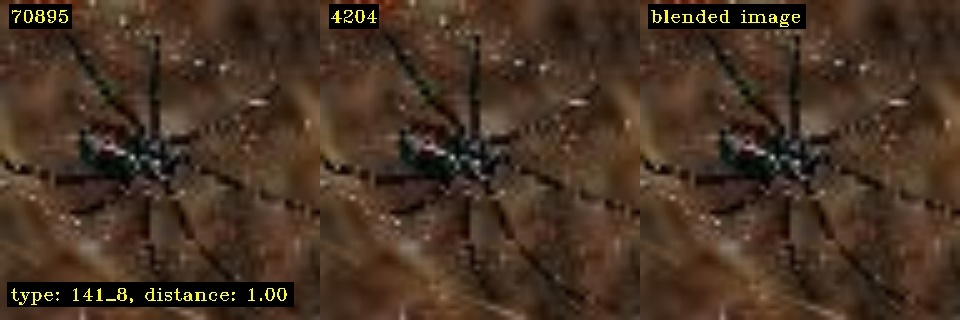
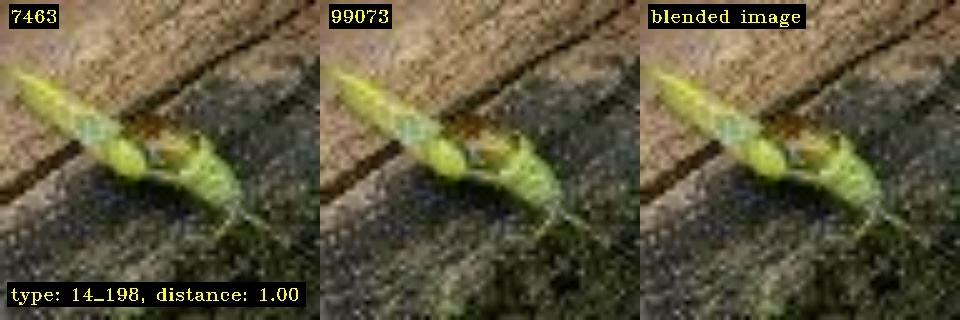
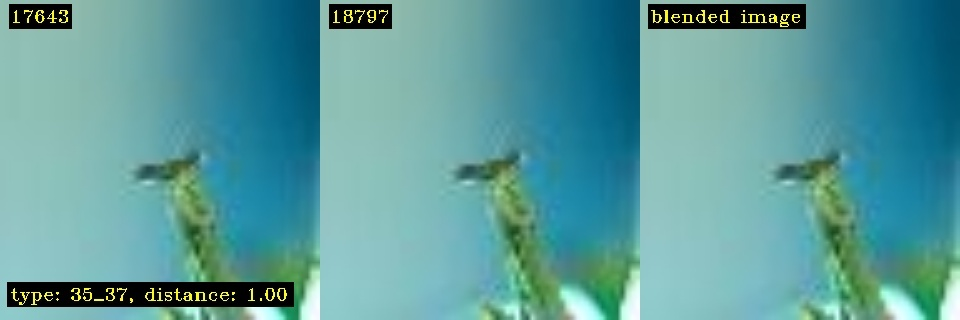
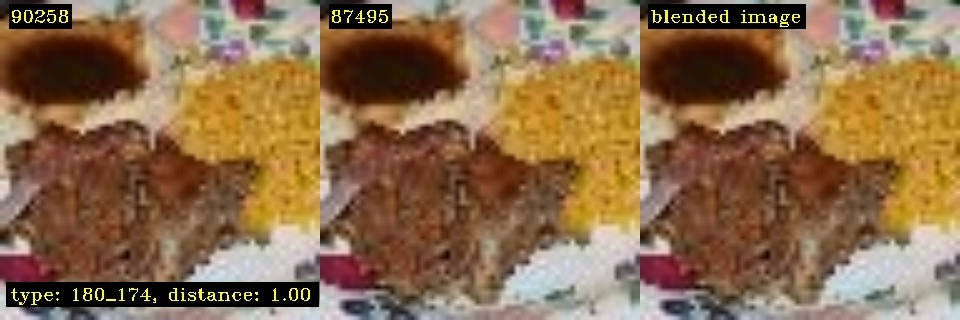
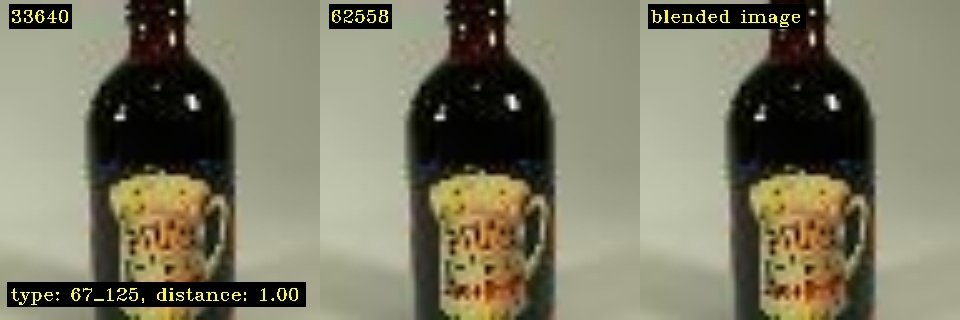
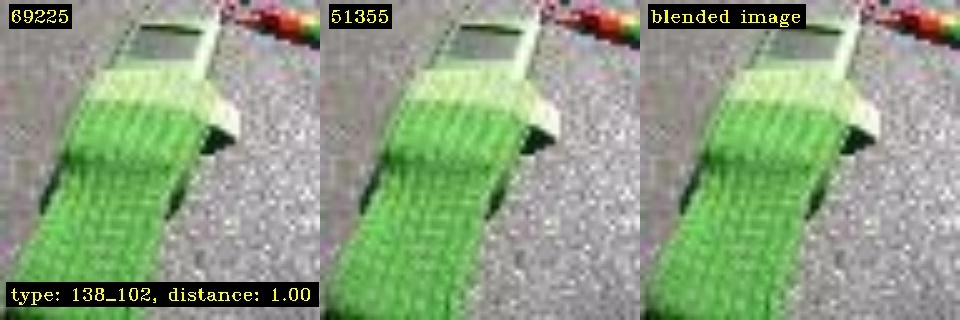
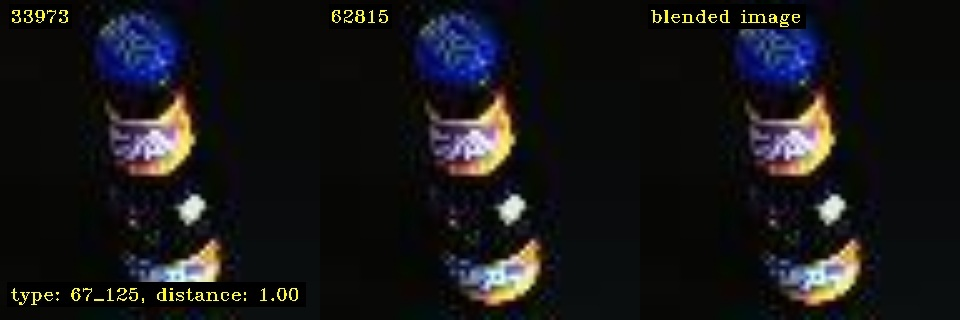
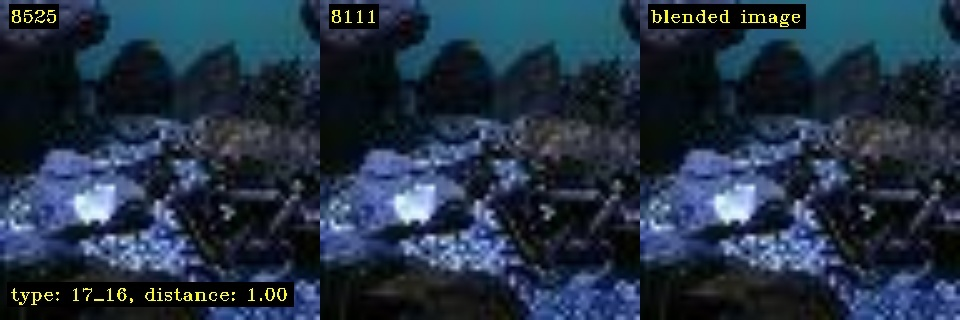

0

In [11]:
fd.vis.duplicates_gallery()

Generating gallery:   0%|          | 0/20 [00:00<?, ?it/s]

Stored outliers visual view in  work_dir/galleries/outliers.html
########################################################################################
Would you like to see awesome visualizations for some of the most popular academic datasets?
Click here to see and learn more: https://app.visual-layer.com/vl-datasets?utm_source=fastdup
########################################################################################



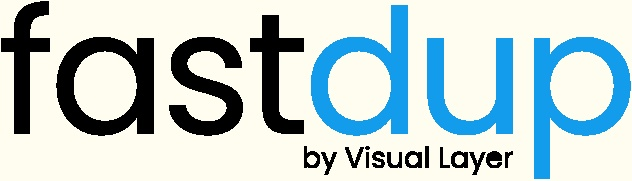
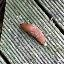
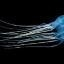
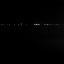
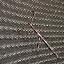
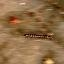
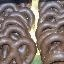
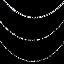
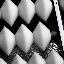
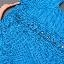
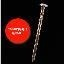
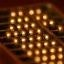
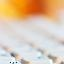
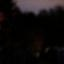
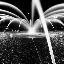
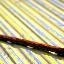
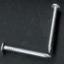
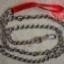
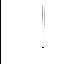
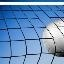
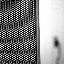

0

In [12]:
fd.vis.outliers_gallery()

Generating gallery:   0%|          | 0/7287 [00:00<?, ?it/s]

Generating gallery:   0%|          | 0/20 [00:00<?, ?it/s]

Stored similar images visual view in  work_dir/galleries/similarity.html
########################################################################################
Would you like to see awesome visualizations for some of the most popular academic datasets?
Click here to see and learn more: https://app.visual-layer.com/vl-datasets?utm_source=fastdup
########################################################################################



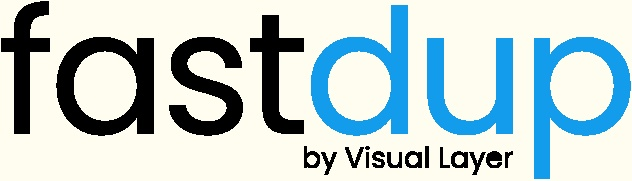
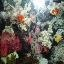
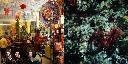
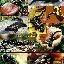
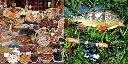
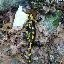
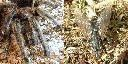
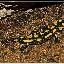
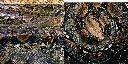
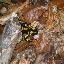
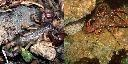
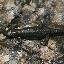
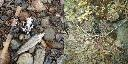
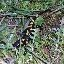
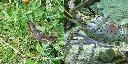
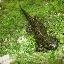
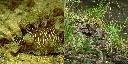
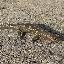
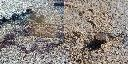
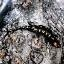
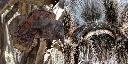
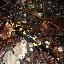
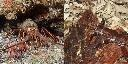
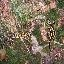
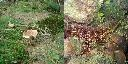
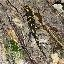
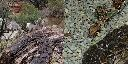
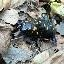
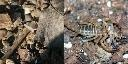
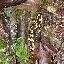
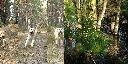
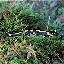
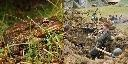
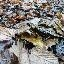
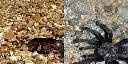
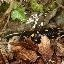
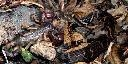
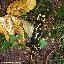
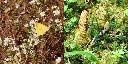
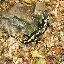
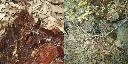

,from,to,label,label2,distance,score,length
4,/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/0/35.jpg,"[/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/190/95331.jpg, /home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/85/42517.jpg]","[0, 0]","[190, 85]","[0.905423, 0.906011]",0.0,2
14,/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/1/513.jpg,"[/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/166/83446.jpg, /home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/85/42716.jpg]","[1, 1]","[166, 85]","[0.907565, 0.911764]",0.0,2
16,/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/1/515.jpg,"[/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/93/46608.jpg, /home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/9/4557.jpg]","[1, 1]","[93, 9]","[0.931858, 0.933797]",0.0,2
19,/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/1/521.jpg,"[/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/5/2731.jpg, /home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/5/2756.jpg]","[1, 1]","[5, 5]","[0.915641, 0.916001]",0.0,2
68,/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/1/650.jpg,"[/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/17/8647.jpg, /home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/7/3800.jpg]","[1, 1]","[17, 7]","[0.909015, 0.923444]",0.0,2
...,...,...,...,...,...,...,...
7273,/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/99/49882.jpg,"[/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/99/49977.jpg, /home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/99/49544.jpg]","[99, 99]","[99, 99]","[0.904351, 0.913638]",100.0,2
7275,/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/99/49895.jpg,"[/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/99/49799.jpg, /home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/99/49806.jpg]","[99, 99]","[99, 99]","[0.92261, 0.92414]",100.0,2
7279,/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/99/49919.jpg,"[/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/99/49734.jpg, /home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/99/49875.jpg]","[99, 99]","[99, 99]","[0.904262, 0.913118]",100.0,2
7283,/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/99/49940.jpg,"[/home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/99/49877.jpg, /home/dnth/.cache/huggingface/datasets/tiny-imagenet/jpg_images/99/49858.jpg]","[99, 99]","[99, 99]","[0.91175, 0.914616]",100.0,2


In [13]:
fd.vis.similarity_gallery(slice='diff')

## Interactive Exploration
In addition to the static visualizations presented above, fastdup also offers interactive exploration of the dataset.

To explore the dataset and issues interactively in a browser, run:

In [ ]:
fd.explore()

> 🗒 **Note** - This currently requires you to sign-up (for free) to view the interactive exploration. Alternatively, you can visualize fastdup in a non-interactive way using fastdup's built in galleries shown in the upcoming cells.

You'll be presented with a web interface that lets you conveniently view, filter, and curate your dataset in a web interface.


![image.png](https://vl-blog.s3.us-east-2.amazonaws.com/fastdup_assets/cloud_preview.gif)

## Wrap Up

That's a wrap! In this notebook, we showed how to get mislabels from a labeled dataset.


Next, feel free to check out other tutorials -

+ ⚡ [**Quickstart**](https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/quick-dataset-analysis.ipynb): Learn how to install fastdup, load a dataset and analyze it for potential issues such as duplicates/near-duplicates, broken images, outliers, dark/bright/blurry images, and view visually similar image clusters. If you're new, start here!
+ 🧹 [**Clean Image Folder**](https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/cleaning-image-dataset.ipynb): Learn how to analyze and clean a folder of images from potential issues and export a list of problematic files for further action. If you have an unorganized folder of images, this is a good place to start.
+ 🖼 [**Analyze Image Classification Dataset**](https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/analyzing-image-classification-dataset.ipynb): Learn how to load a labeled image classification dataset and analyze for potential issues. If you have labeled ImageNet-style folder structure, have a go!
+ 🎁 [**Analyze Object Detection Dataset**](https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/analyzing-object-detection-dataset.ipynb): Learn how to load bounding box annotations for object detection and analyze for potential issues. If you have a COCO-style labeled object detection dataset, give this example a try. 

As usual, feedback is welcome! Questions? Drop by our [Slack channel](https://visualdatabase.slack.com/join/shared_invite/zt-19jaydbjn-lNDEDkgvSI1QwbTXSY6dlA#/shared-invite/email) or open an issue on [GitHub](https://github.com/visual-layer/fastdup/issues).


<center> 
<div style="text-align: center; margin-top:50px;">
    <a href="https://visual-layer.com/" style="padding:10px;">
                <img alt="site" src="https://vl-blog.s3.us-east-2.amazonaws.com/imgs/web.png" width="50"></a>
    <a href="https://medium.com/visual-layer" style="padding:10px;">
                <img alt="blog" src="https://vl-blog.s3.us-east-2.amazonaws.com/imgs/forum.png" width="50"></a>
    <a href="https://github.com/visual-layer/fastdup" style="padding:10px;">
                <img alt="github" src="https://vl-blog.s3.us-east-2.amazonaws.com/imgs/github.png" width="50"></a>
    <a href="https://discord.com/invite/Dqw458EG/" style="padding:10px;">
                <img alt="slack" src="https://vl-blog.s3.us-east-2.amazonaws.com/imgs/discord.png" width="50"></a>
    <a href="https://www.linkedin.com/company/visual-layer/" style="padding:10px;">
                <img alt="linkedin" src="https://vl-blog.s3.us-east-2.amazonaws.com/imgs/linkedin.png" width="50"></a>
    <a href="https://www.youtube.com/@visual-layer" style="padding:10px;">
                <img alt="youtube" src="https://vl-blog.s3.us-east-2.amazonaws.com/imgs/youtube.png" width="50"></a>
    <a href="https://twitter.com/visual_layer" style="padding:10px;">
                <img alt="twitter" src="https://vl-blog.s3.us-east-2.amazonaws.com/imgs/x.png" width="50"></a>
</div>
<br>
<div style="text-align:center; font-family:'DM Sans',sans-serif; font-style:italic; font-size:12px; max-width:600px; margin: 20px auto auto;">
    <img style="width:200px" alt="logo" src="https://d2iycffepdu1yp.cloudfront.net/design-assets/VL_horizontal_logo.png" width=300>
    <div style="margin-top:20px;">Copyright © 2024 Visual Layer. All rights reserved.</div>
</div>

</center> 